# PM2 - Conditioning and Sensitivity
Team: Camille Wardlaw, Manuel Valencia, Demircan Tas\\
Scope: Tasks C (Conditioning) and D (Sensitivity)

In [1]:
# Ensure inline plotting in notebooks
try:
    import matplotlib
    if 'inline' not in matplotlib.get_backend().lower():
        matplotlib.use('module://matplotlib_inline.backend_inline')
except Exception:
    pass


## Overview
- Quick regression sanity, then Conditioning (Task C) and Sensitivity (Task D).
- Task C: focus on steady L — cond vs N, aspect ratio, absorption, invariance, and practical tolerances.
- Task D: dp plateau selection, relative sensitivities per hydrophone, and transient note for α.


## Quick Regression (sanity)

COMPLETE SONAR MODEL TEST SUITE

PART A: MODEL FUNCTIONALITY TESTS

TEST 1: Matrix Dimensions
----------------------------------------
✓ PASSED: Matrix dimensions correct

TEST 2: Zero Input Response
----------------------------------------
✓ PASSED: Zero state remains stable

TEST 3: Source Excitation
----------------------------------------
✓ PASSED: Source generates signal: 9.51e-01 Pa

TEST 4: CFL Condition
----------------------------------------
✓ PASSED: Timestep 0.001241 respects CFL

TEST 5: Hydrophone Configuration
----------------------------------------
✓ PASSED: 5 hydrophones configured

TEST 6: Short-term Stability
----------------------------------------
started running a simple solver, please wait...
✓ PASSED: No immediate divergence

PART B: JACOBIAN TEST BENCH

TEST 7: Linear System Check
----------------------------------------
✓ PASSED: Jacobian equals A matrix (linear system)

TEST 8: Finite Difference Verification
----------------------------------------
  dx = 1.

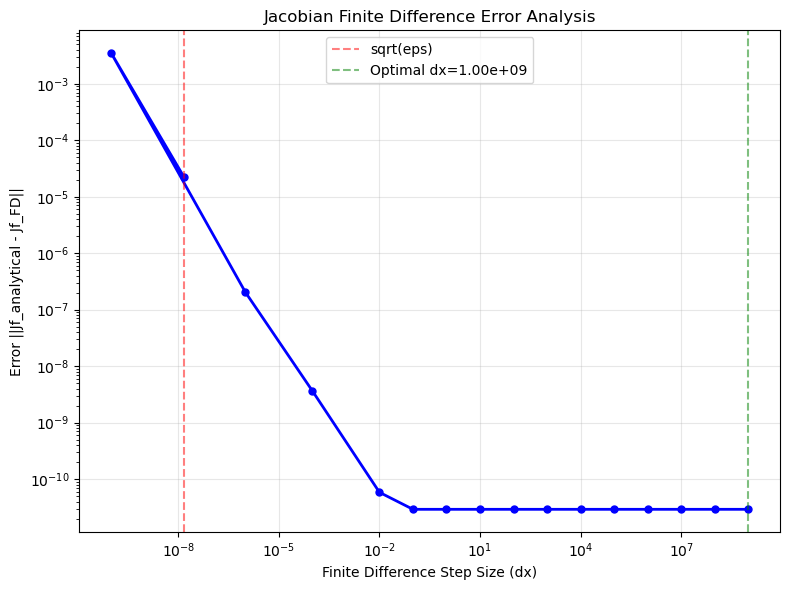


COMPLETE TEST SUMMARY
Total Tests Passed: 10
Total Tests Failed: 0
Overall Success Rate: 100.0%

✓ ALL TESTS PASSED!
PM2 regression summary — passed: 10, failed: 0


In [2]:
# Run quick regression (non-fatal)
try:
    # Force a non-interactive backend if matplotlib is present
    try:
        import matplotlib
        # keep inline backend if active; otherwise use Agg for headless
        if 'inline' not in matplotlib.get_backend().lower():
            matplotlib.use('Agg')
    except Exception:
        pass
    from test_Sonar import test_sonar_complete
    passed, failed = test_sonar_complete()
    print(f'PM2 regression summary — passed: {passed}, failed: {failed}')
except Exception as e:
    print('PM2 regression skipped due to environment:', type(e).__name__, e)


## Task D - Setup (helpers)


In [3]:
# Helpers: model I/O and steady QoI
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from getParam_Sonar import getParam_Sonar

def build_C(p):
    H = p['hydrophones']['n_phones']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    C = np.zeros((H, 2*N))
    z_pos = p['hydrophones']['z_pos']
    for h, x_idx in enumerate(p['hydrophones']['x_indices']):
        if x_idx < Nx:
            k = x_idx * Nz + z_pos
            C[h, k] = 1.0
    return C

def to_dense(A):
    return A.toarray() if sp.issparse(A) else np.array(A)

def extract_L(p):
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    Lblk = A[N:, :N]
    return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)

def solve_steady(p, u0=1.0):
    A, B = p['A'], p['B']
    rhs = -(B * float(u0)).toarray().ravel() if sp.issparse(B) else -(B * float(u0)).ravel()
    if sp.issparse(A):
        x = spsolve(A, rhs)
    else:
        x = np.linalg.solve(A, rhs)
    return x.reshape((-1,1))

def rebuild_params_like(p, **overrides):
    q = dict(p)
    is_sparse = sp.issparse(p['A'])
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    # Update alpha/c by reconstructing A blocks
    alpha_new = overrides.get('alpha', p['alpha'])
    c_new = overrides.get('c', p['c'])
    c_old = p['c']
    scale = (c_new / c_old)**2 if 'c' in overrides else 1.0
    if is_sparse:
        L_blk = A[N:, :N]
        I_N = sp.eye(N, format='csr')
        L_new = L_blk * scale
        A_new = sp.bmat([[sp.csr_matrix((N, N)), I_N],
                         [L_new, -alpha_new * I_N]], format='csr')
    else:
        L_blk = A[N:, :N]
        I_N = np.eye(N)
        L_new = L_blk * scale
        A_new = np.block([[np.zeros((N, N)), I_N],
                         [L_new, -alpha_new * I_N]])
    q['A'] = A_new
    q['alpha'] = alpha_new
    q['c'] = c_new
    # Update B if sonar position overrides are provided
    si = overrides.get('sonar_ix', p['sonar_ix'])
    sj = overrides.get('sonar_iz', p['sonar_iz'])
    if ('sonar_ix' in overrides) or ('sonar_iz' in overrides):
        def idx(i,j):
            return i * Nz + j
        if is_sparse:
            B = sp.lil_matrix((2*N,1), dtype=float)
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B.tocsr()
        else:
            B = np.zeros((2*N,1))
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B
        q['sonar_ix'] = si
        q['sonar_iz'] = sj
    # Optional: rebuild with new absorbing strength (affects L structure)
    if 'absorb_strength' in overrides:
        from getParam_Sonar import getParam_Sonar
        Nx, Nz, Lx, Lz = q['Nx'], q['Nz'], q['Lx'], q['Lz']
        q_new, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=bool(is_sparse), absorb_strength=overrides['absorb_strength'])
        # Carry over updated alpha/c if present
        q_new['alpha'] = q.get('alpha', q_new['alpha'])
        q_new['c'] = q.get('c', q_new['c'])
        q = q_new
    return q

def compute_y(p, u0=1.0):
    return (build_C(p) @ solve_steady(p, u0=u0)).reshape(-1,1)


## Task D - Enhanced dp selection and sensitivities

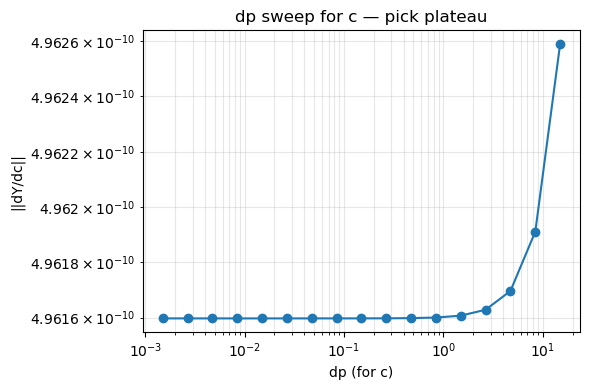

Recommended dp for c (plateau heuristic): 8.435e-03


In [4]:
# dp sweep for finite-difference sensitivity and plateau detection
import numpy as np
import matplotlib.pyplot as plt

# Assumes helpers (build_C, solve_steady, rebuild_params_like) and compute_y() are defined above.
from getParam_Sonar import getParam_Sonar

def fd_sens_norm(p, pname, dp):
    y0 = compute_y(p)

    if pname in ('sonar_ix','sonar_iz'):
        # one-grid-step change for index parameters
        step = int(np.sign(dp) or 1)
        y1 = compute_y(rebuild_params_like(p, **{pname: int(p[pname]) + step}))
        dY = (y1 - y0) / 1.0
    else:
        pp = rebuild_params_like(p, **{pname: p[pname] + dp})
        pm = rebuild_params_like(p, **{pname: p[pname] - dp})
        dY = (compute_y(pp) - compute_y(pm)) / (2*dp)
    return float(np.linalg.norm(dY))

def sweep_dp(p, pname, dp_values):
    vals = []
    for dp in dp_values:
        try:
            vals.append(fd_sens_norm(p, pname, dp))
        except Exception:
            vals.append(np.nan)
    return np.array(vals)

# Demonstration: dp plateau for c
Nx, Nz, Lx, Lz = 50, 50, 100, 100
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)

dp_c = np.logspace(-6, -2, 17) * p['c']
vals_c = sweep_dp(p, 'c', dp_c)

plt.figure(figsize=(6,4))
plt.loglog(dp_c, vals_c, 'o-')
plt.xlabel('dp (for c)'); plt.ylabel('||dY/dc||')
plt.title('dp sweep for c — pick plateau')
plt.grid(True, which='both', alpha=0.3); plt.tight_layout(); plt.show()

logx = np.log10(dp_c); logy = np.log10(vals_c)
slope = np.gradient(logy, logx)
idx = int(np.nanargmin(np.abs(slope)))
dp_rec_c = dp_c[idx]
print(f'Recommended dp for c (plateau heuristic): {dp_rec_c:.3e}')


c: recommended dp = 6.962e-03


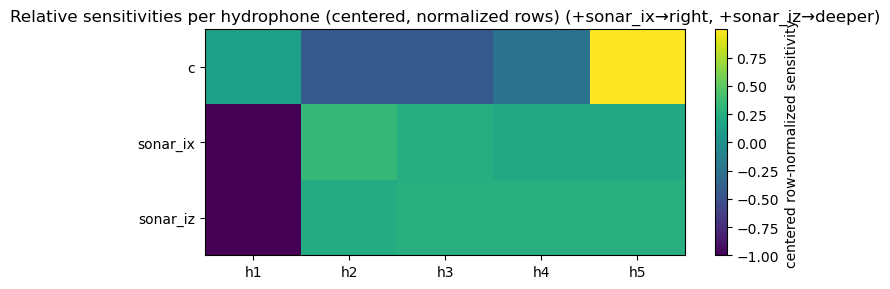

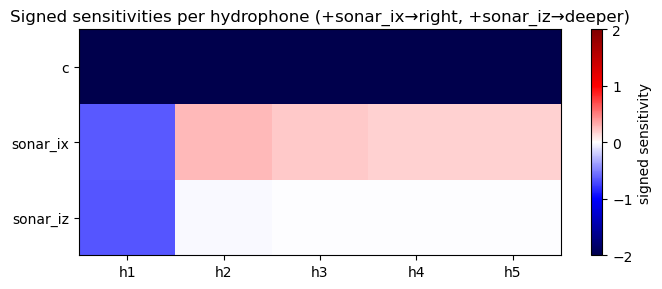

In [5]:

# Relative sensitivities across parameters using recommended dp
import numpy as np
import matplotlib.pyplot as plt

def pick_dp(dp_vals, vals):
    # robust plateau finder on log-log; fallback to median if all-NaN/inf/zero
    dp_vals = np.asarray(dp_vals)
    vals = np.asarray(vals)
    m = np.isfinite(dp_vals) & np.isfinite(vals) & (vals > 0)
    if np.count_nonzero(m) >= 3:
        lx, ly = np.log10(dp_vals[m]), np.log10(vals[m])
        slope = np.gradient(ly, lx)
        k_rel = int(np.nanargmin(np.abs(slope)))
        return dp_vals[m][k_rel]
    # fallback: mid dp
    return np.median(dp_vals)

# Parameters to assess
params = ['c']  # absorb_strength moved to Task C; keep Task D focused on physics/source
dp_map = {}
for pname in params:
    if pname == 'c':
        dp_vals = np.logspace(-6, -2, 13) * p['c']
    else:
        dp_vals = np.logspace(-4, 0, 13)
    vals = sweep_dp(p, pname, dp_vals)
    dp_map[pname] = pick_dp(dp_vals, vals)
    print(f"{pname}: recommended dp = {dp_map[pname]:.3e}")

def relative_sensitivity(p, pname, dp):
    y0 = compute_y(p).flatten(); eps = 1e-16
    y0abs = np.abs(y0) + eps
    if pname in ('sonar_ix','sonar_iz'):
        y1 = compute_y(rebuild_params_like(p, **{pname: int(p[pname])+1})).flatten()
        dY = (y1 - y0)/1.0
        pscale = (p['dx'] if pname=='sonar_ix' else p['dz'])
    else:
        pp = rebuild_params_like(p, **{pname: p[pname] + dp})
        pm = rebuild_params_like(p, **{pname: p[pname] - dp})
        dY = (compute_y(pp).flatten() - compute_y(pm).flatten())/(2*dp)
        pscale = abs(p[pname]) if p[pname] != 0 else 1.0
    rel = (dY / y0abs) * pscale
    return rel

# Build per-hydrophone sensitivities for chosen parameters + source indices
names = params + ['sonar_ix','sonar_iz']
dp_map.update({'sonar_ix': 1, 'sonar_iz': 1})

S = []
for pname in names:
    rel = relative_sensitivity(p, pname, dp_map[pname])
    S.append(rel)
S = np.vstack(S)

# Heatmap (normalized rows)
S_center = S - S.mean(axis=1, keepdims=True)
S_norm = S_center / (np.max(np.abs(S_center), axis=1, keepdims=True) + 1e-16)
plt.figure(figsize=(7,3))
plt.imshow(S_norm, aspect='auto', cmap='viridis')
plt.colorbar(label='centered row-normalized sensitivity')
plt.yticks(range(len(names)), names)
plt.xticks(range(S.shape[1]), [f"h{i+1}" for i in range(S.shape[1])])
plt.title('Relative sensitivities per hydrophone (centered, normalized rows) (+sonar_ix→right, +sonar_iz→deeper)')
plt.tight_layout(); plt.show()

# Signed heatmap (not normalized)
plt.figure(figsize=(7,3))
plt.imshow(S, aspect='auto', cmap='seismic', vmin=-np.max(np.abs(S)), vmax=np.max(np.abs(S)))
plt.colorbar(label='signed sensitivity')
plt.yticks(range(len(names)), names)
plt.xticks(range(S.shape[1]), [f"h{i+1}" for i in range(S.shape[1])])
plt.title('Signed sensitivities per hydrophone (+sonar_ix→right, +sonar_iz→deeper)')
plt.tight_layout(); plt.show()


## Optional — Steady Adjoint for c (continuous parameter)


Adjoint vs FD (relative sensitivity for c) 
  L∞ diff: 4.9718333894333e-09
  L2 diff: 8.303380564663894e-09


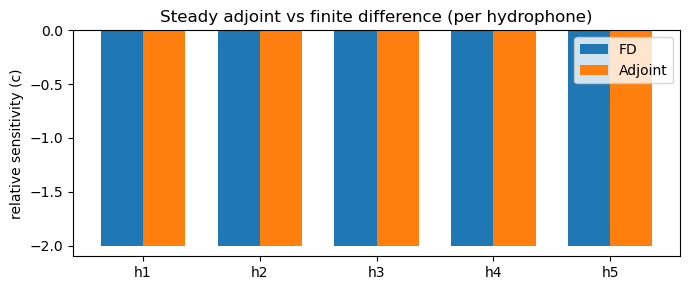

In [6]:
# Steady adjoint sensitivity for c; compare to FD per-hydrophone
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Reuse existing p if available; otherwise create a baseline
try:
    p
except NameError:
    from getParam_Sonar import getParam_Sonar
    Nx, Nz, Lx, Lz = 20, 10, 100, 50
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)

Nx, Nz = p['Nx'], p['Nz']
N = Nx * Nz
A = p['A']

# Forward steady solve and QoI
u0 = 1.0
try:
    y0 = compute_y(p, u0=u0).flatten()
    x = solve_steady(p, u0=u0)
except Exception:
    # Minimal inline fallbacks if helpers are missing
    from scipy.sparse.linalg import spsolve
    A, B = p['A'], p['B']
    rhs = -(B * float(u0)).toarray().ravel() if sp.issparse(B) else -(B * float(u0)).ravel()
    x = (spsolve(A, rhs) if sp.issparse(A) else np.linalg.solve(A, rhs)).reshape((-1,1))
    # Build C (pressure selector)
    H = p['hydrophones']['n_phones']
    C = np.zeros((H, 2*N))
    z_pos = p['hydrophones']['z_pos']
    for h, xi in enumerate(p['hydrophones']['x_indices']):
        if xi < Nx:
            C[h, xi*Nz + z_pos] = 1.0
    y0 = (C @ x).flatten()

# Build C for adjoint RHS
C = build_C(p)

# Solve adjoint for all hydrophones: A^T Lambda = C^T
H = C.shape[0]
Lam = np.zeros((2*N, H))
AT = A.T
for i in range(H):
    rhs = C.T[:, i]
    Lam[:, i] = (spsolve(AT, rhs) if sp.issparse(AT) else np.linalg.solve(AT, rhs))

# Sensitivity formula: dJ/dc = -lambda_w^T (dL/dc p)
L = extract_L(p)
dpdc_L = (2.0/max(p['c'], 1e-16)) * L
p_vec = x[:N].ravel()
dJ_dc = []
for i in range(H):
    lam_w = Lam[N:, i]
    dJ_dc.append(- lam_w @ (dpdc_L @ p_vec))
dJ_dc = np.array(dJ_dc)

# Relative adjoint sensitivity per hydrophone
eps = 1e-16
Srel_adj = (dJ_dc * p['c']) / (np.abs(y0) + eps)

# Finite difference baseline (if dp_map from earlier is present, use it)
try:
    dp_fd = dp_map['c']
except Exception:
    dp_fd = 1e-4 * p['c']
pp = rebuild_params_like(p, c=p['c'] + dp_fd)
pm = rebuild_params_like(p, c=p['c'] - dp_fd)
y_pp = compute_y(pp, u0=u0).flatten()
y_pm = compute_y(pm, u0=u0).flatten()
Srel_fd = ((y_pp - y_pm) / (2*dp_fd)) * (p['c'] / (np.abs(y0) + eps))

print('Adjoint vs FD (relative sensitivity for c) ')
print('  L∞ diff:', float(np.max(np.abs(Srel_adj - Srel_fd))))
print('  L2 diff:', float(np.linalg.norm(Srel_adj - Srel_fd)))

# Plot comparison per hydrophone
labels = [f'h{i+1}' for i in range(H)]
xpos = np.arange(H)
plt.figure(figsize=(7,3))
plt.bar(xpos-0.18, Srel_fd, width=0.36, label='FD')
plt.bar(xpos+0.18, Srel_adj, width=0.36, label='Adjoint')
plt.axhline(0, color='k', linewidth=0.5)
plt.xticks(xpos, labels)
plt.ylabel('relative sensitivity (c)')
plt.title('Steady adjoint vs finite difference (per hydrophone)')
plt.legend(); plt.tight_layout(); plt.show()


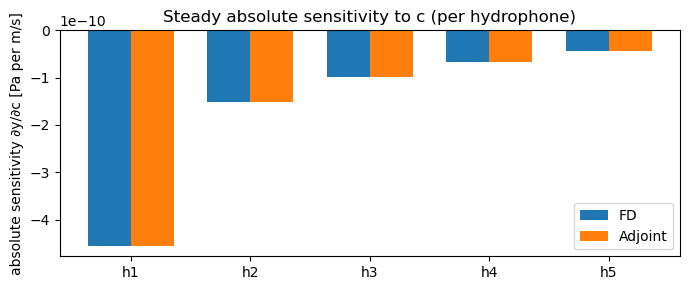

In [7]:
# Absolute (steady) sensitivity for c — per hydrophone (FD vs Adjoint)
import numpy as np
import matplotlib.pyplot as plt

# Use values from previous cell if available
try:
    dJ_dc
    y_pp, y_pm
    dp_fd
except NameError:
    print('Adjoint baseline not found; please run the previous cell first.')
else:
    dY_dc_fd = (y_pp - y_pm) / (2*dp_fd)
    labels = [f'h{i+1}' for i in range(len(dJ_dc))]
    xpos = np.arange(len(labels))
    plt.figure(figsize=(7,3))
    plt.bar(xpos-0.18, dY_dc_fd, width=0.36, label='FD')
    plt.bar(xpos+0.18, dJ_dc,   width=0.36, label='Adjoint')
    plt.axhline(0, color='k', linewidth=0.5)
    plt.xticks(xpos, labels)
    plt.ylabel('absolute sensitivity ∂y/∂c [Pa per m/s]')
    plt.title('Steady absolute sensitivity to c (per hydrophone)')
    plt.legend(); plt.tight_layout(); plt.show()


Transient QoI note: α affects dynamics (peak |y(t)|) — retain PM2 transient section to demonstrate this, while steady QoI masks α sensitivity.

## Transient QoI - α effect (peak hydrophone amplitude)

Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog

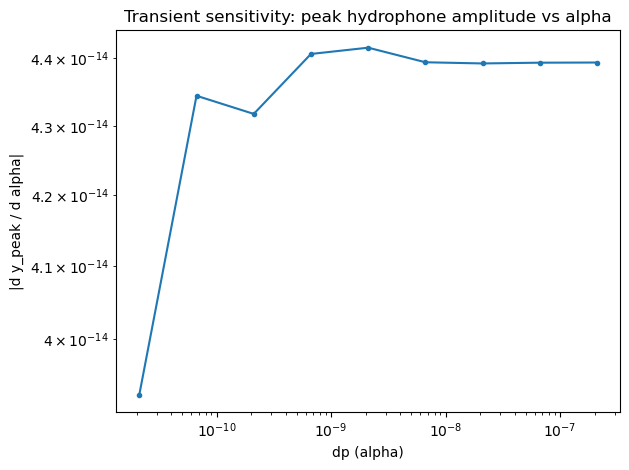

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from simpleLeapFrog import LeapfrogSolver
from eval_f_Sonar import eval_f_Sonar
from eval_u_Sonar import eval_u_Sonar
from eval_g_Sonar import eval_g_Sonar

import math

# Use a short leapfrog run; define QoI as max |y(t)| across hydrophones
def peak_hydrophone_amplitude(p, num_iter, dt):
    # Use baseline x_start from fresh params to align shapes
    q, x_start, _, _, _ = getParam_Sonar(p['Nx'], p['Nz'], p['Lx'], p['Lz'], UseSparseMatrices=sp.issparse(p['A']))
    # copy A/B from p (may be modified by rebuild_params_like)
    q['A'] = p['A']; q['B'] = p['B']; q['alpha'] = p['alpha']; q['c'] = p['c']
    X, t = LeapfrogSolver(eval_f_Sonar, x_start, q, eval_u_Sonar, num_iter, dt, visualize=False)
    peak = 0.0
    for i in range(len(t)):
        y = eval_g_Sonar(X[:, i], q)
        peak = max(peak, float(np.max(np.abs(y))))
    return peak

Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, x0, t0, t1, dt_max = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
dt = dt_max * 0.5
num_iter = int(max(10, (t1 - t0) / dt))

eps = np.finfo(float).eps
base_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_sweep = base_alpha * (10.0 ** np.linspace(-3, 1, 9))

y0_peak = peak_hydrophone_amplitude(p, num_iter, dt)
sens = []
for dp in dp_sweep:
    p_pert = rebuild_params_like(p, alpha=p['alpha'] + dp)
    y1_peak = peak_hydrophone_amplitude(p_pert, num_iter, dt)
    sens.append(abs((y1_peak - y0_peak) / dp))

plt.loglog(dp_sweep, sens, '.-')
plt.xlabel('dp (alpha)')
plt.ylabel('|d y_peak / d alpha|')
plt.title('Transient sensitivity: peak hydrophone amplitude vs alpha')
plt.tight_layout(); plt.show()


Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog

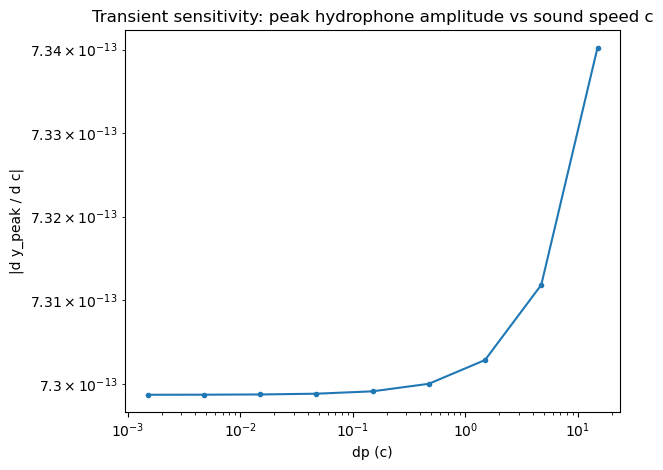

In [9]:
from getParam_Sonar import getParam_Sonar

# Transient QoI — c effect (peak hydrophone amplitude)
import numpy as np
import math

# Use the same peak QoI function defined above (peak_hydrophone_amplitude)
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, x0, t0, t1, dt_max = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)

dt = dt_max * 0.5
num_iter = int(max(10, (t1 - t0) / dt))

eps = np.finfo(float).eps
base_c = p['c']
# Sweep dp relative to c
dp_sweep_c = base_c * (10.0 ** np.linspace(-6, -2, 9))

y0_peak = peak_hydrophone_amplitude(p, num_iter, dt)
sens_c = []
for dp in dp_sweep_c:
    p_pert = rebuild_params_like(p, c=base_c + dp)
    y1_peak = peak_hydrophone_amplitude(p_pert, num_iter, dt)
    sens_c.append(abs((y1_peak - y0_peak) / dp))

plt.loglog(dp_sweep_c, sens_c, '.-')
plt.xlabel('dp (c)')
plt.ylabel('|d y_peak / d c|')
plt.title('Transient sensitivity: peak hydrophone amplitude vs sound speed c')
plt.tight_layout(); plt.show()


Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!


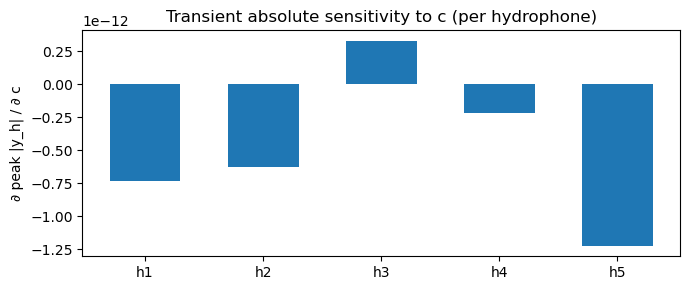

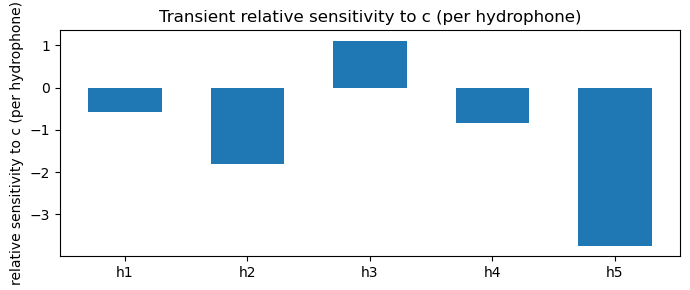

In [10]:
# Transient per-hydrophone peak sensitivity to c
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from simpleLeapFrog import LeapfrogSolver
from eval_f_Sonar import eval_f_Sonar
from eval_u_Sonar import eval_u_Sonar
from eval_g_Sonar import eval_g_Sonar
from getParam_Sonar import getParam_Sonar

def peak_per_hydrophone(p, num_iter, dt):
    # Returns vector of per-hydrophone max |y_h(t)| over the run
    q, x_start, _, _, _ = getParam_Sonar(p['Nx'], p['Nz'], p['Lx'], p['Lz'], UseSparseMatrices=sp.issparse(p['A']))
    q['A'] = p['A']; q['B'] = p['B']; q['alpha'] = p['alpha']; q['c'] = p['c']
    X, t = LeapfrogSolver(eval_f_Sonar, x_start, q, eval_u_Sonar, num_iter, dt, visualize=False)
    H = p['hydrophones']['n_phones']
    peaks = np.zeros(H)
    for i in range(len(t)):
        y = eval_g_Sonar(X[:, i], q).flatten()
        peaks = np.maximum(peaks, np.abs(y))
    return peaks

# Baseline peaks
peaks0 = peak_per_hydrophone(p, num_iter, dt)

# Perturbed peaks (c + dp)
dp = max(1e-6, 1e-3 * p['c'])
peaks1 = peak_per_hydrophone(rebuild_params_like(p, c=p['c'] + dp), num_iter, dt)

# Absolute and relative sensitivities per hydrophone
dpeaks_dc = (peaks1 - peaks0) / dp
eps = 1e-16
Srel_peak = (dpeaks_dc * p['c']) / (peaks0 + eps)

labels = [f'h{i+1}' for i in range(len(peaks0))]
xpos = np.arange(len(labels))
plt.figure(figsize=(7,3))
plt.bar(xpos, dpeaks_dc, width=0.6)
plt.xticks(xpos, labels)
plt.ylabel('∂ peak |y_h| / ∂ c')
plt.title('Transient absolute sensitivity to c (per hydrophone)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3))
plt.bar(xpos, Srel_peak, width=0.6)
plt.xticks(xpos, labels)
plt.ylabel('relative sensitivity to c (per hydrophone)')
plt.title('Transient relative sensitivity to c (per hydrophone)')
plt.tight_layout(); plt.show()


## Conclusions
- Summarize conditioning trends vs alpha/grid.
- Report stable dp ranges and most influential parameters.
- Note pitfalls (e.g., low damping, boundary extremes).